# Tutorial 04: Visualizing Experiment Results

This tutorial describes the process of visualizing the results of Flow experiments, and of replaying them. 

**Note:** This tutorial is only relevant if you use SUMO as a simulator. We currently do not support policy replay nor data collection when using Aimsun. The only exception is for reward plotting, which is independent on whether you have used SUMO or Aimsun during training.

## 1. Visualization components

The visualization of simulation results breaks down into three main components:

- **reward plotting**: Visualization of the reward function is an essential step in evaluating the effectiveness and training progress of RL agents.

- **policy replay**: Flow includes tools for visualizing trained policies using SUMO's GUI. This enables more granular analysis of policies beyond their accrued reward, which in turn allows users to tweak actions, observations and rewards in order to produce some desired behavior. The visualizers also generate plots of observations and a plot of the reward function over the course of the rollout.

- **data collection and analysis**: Any Flow experiment can output its simulation data to a CSV file, `emission.csv`, containing the contents of SUMO's built-in `emission.xml` files. This file contains various data such as the speed, position, time, fuel consumption and many other metrics for every vehicle in the network and at each time step of the simulation. Once you have generated the `emission.csv` file, you can open it and read the data it contains using Python's [csv library](https://docs.python.org/3/library/csv.html) (or using Excel).

Visualization is different depending on which reinforcement learning library you are using, if any. Accordingly, the rest of this tutorial explains how to plot rewards, replay policies and collect data when using either no RL library, RLlib, or stable-baselines. 

**Contents:**

[How to visualize using SUMO without training](#2.1---Using-SUMO-without-training)

[How to visualize using SUMO with RLlib](#2.2---Using-SUMO-with-RLlib)

[**_Example: visualize data on a ring trained using RLlib_**](#2.3---Example:-Visualize-data-on-a-ring-trained-using-RLlib)


## 2. How to visualize

### 2.1 - Using SUMO without training

_In this case, since there is no training, there is no reward to plot and no policy to replay._

#### Data collection and analysis

SUMO-only experiments can generate emission CSV files seamlessly:

First, you have to tell SUMO to generate the `emission.xml` files. You can do that by specifying `emission_path` in the simulation parameters (class `SumoParams`), which is the path where the emission files will be generated. For instance:

In [1]:
from flow.core.params import SumoParams

sim_params = SumoParams(sim_step=0.1, render=True, emission_path='data')

Then, you have to tell Flow to convert these XML emission files into CSV files. To do that, pass in `convert_to_csv=True` to the `run` method of your experiment object. For instance:

```python
exp.run(1, convert_to_csv=True)
```

When running experiments, Flow will now automatically create CSV files next to the SUMO-generated XML files.

### 2.2 - Using SUMO with RLlib 

#### Reward plotting

RLlib supports reward visualization over the period of the training using the `tensorboard` command. It takes one command-line parameter, `--logdir`, which is an RLlib result directory. By default, it would be located within an experiment directory inside your `~/ray_results` directory. 

An example call would look like:

`tensorboard --logdir ~/ray_results/experiment_dir/result/directory`

You can also run `tensorboard --logdir ~/ray_results` if you want to select more than just one experiment.

If you do not wish to use `tensorboard`, an other way is to use our `flow/visualize/plot_ray_results.py` tool. It takes as arguments:

- the path to the `progress.csv` file located inside your experiment results directory (`~/ray_results/...`),
- the name(s) of the column(s) you wish to plot (reward or other things).

An example call would look like:

`flow/visualize/plot_ray_results.py ~/ray_results/experiment_dir/result/progress.csv training/return-average training/return-min`

If you do not know what the names of the columns are, run the command without specifying any column:

`flow/visualize/plot_ray_results.py ~/ray_results/experiment_dir/result/progress.csv`

and the list of all available columns will be displayed to you.

#### Policy replay

The tool to replay a policy trained using RLlib is located at `flow/visualize/visualizer_rllib.py`. It takes as argument, first the path to the experiment results (by default located within `~/ray_results`), and secondly the number of the checkpoint you wish to visualize (which correspond to the folder `checkpoint_<number>` inside the experiment results directory).

An example call would look like this:

`python flow/visualize/visualizer_rllib.py ~/ray_results/experiment_dir/result/directory 1`

There are other optional parameters which you can learn about by running `visualizer_rllib.py --help`. 

#### Data collection and analysis

Simulation data can be generated the same way as it is done [without training](#2.1---Using-SUMO-without-training).

If you need to generate simulation data after the training, you can run a policy replay as mentioned above, and add the `--gen-emission` parameter.

An example call would look like:

`python flow/visualize/visualizer_rllib.py ~/ray_results/experiment_dir/result/directory 1 --gen_emission`

### 2.3 - Example: Visualize data on a ring trained using RLlib

In [2]:
!pwd  # make sure you are in the flow/tutorials folder

/usr/local/google/home/gilbertbahati/flow/tutorials


The folder `flow/tutorials/data/trained_ring` contains the data generated in `ray_results` after training an agent on a ring scenario for 200 iterations using RLlib (the experiment can be found in `flow/examples/rllib/stabilizing_the_ring.py`).

Let's first have a look at what's available in the `progress.csv` file:

In [3]:
!python ../flow/visualize/plot_ray_results.py data/trained_ring/progress.csv

Columns are: episode_reward_max, episode_reward_min, episode_reward_mean, episode_len_mean, episodes_this_iter, timesteps_this_iter, done, timesteps_total, episodes_total, training_iteration, experiment_id, date, timestamp, time_this_iter_s, time_total_s, pid, hostname, node_ip, time_since_restore, timesteps_since_restore, iterations_since_restore, num_healthy_workers, trial_id, sampler_perf/mean_env_wait_ms, sampler_perf/mean_processing_ms, sampler_perf/mean_inference_ms, info/num_steps_trained, info/num_steps_sampled, info/sample_time_ms, info/load_time_ms, info/grad_time_ms, info/update_time_ms, perf/cpu_util_percent, perf/ram_util_percent, info/learner/default_policy/cur_kl_coeff, info/learner/default_policy/cur_lr, info/learner/default_policy/total_loss, info/learner/default_policy/policy_loss, info/learner/default_policy/vf_loss, info/learner/default_policy/vf_explained_var, info/learner/default_policy/kl, info/learner/default_policy/entropy, info/learner/default_policy/entropy_c

This gives us a list of everything that we can plot. Let's plot the reward and its boundaries:

<IPython.core.display.Javascript object>


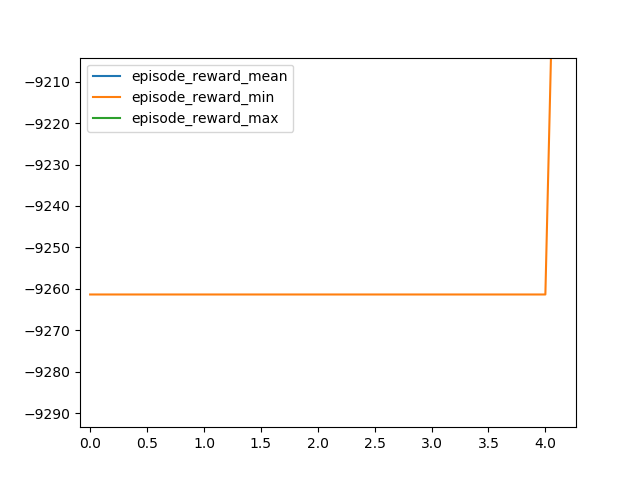

In [10]:
%matplotlib notebook
# if this doesn't display anything, try with "%matplotlib inline" instead
%run ../flow/visualize/plot_ray_results.py data/trained_ring/progress.csv \
episode_reward_mean episode_reward_min episode_reward_max

We can see that the policy had already converged by the iteration 50.

Now let's see what this policy looks like. Run the following script, then click on the green arrow to run the simulation (you may have to click several times).

In [ ]:
!python ../flow/visualize/visualizer_rllib.py data/trained_ring 200 --horizon 2000

The RL agent is properly stabilizing the ring! 

Indeed, without an RL agent, the vehicles start forming stop-and-go waves which significantly slows down the traffic, as you can see in this simulation:

In [ ]:
!python ../examples/simulate.py ring

In the trained ring folder, there is a checkpoint generated every 20 iterations. Try to run the second previous command but replace 200 by 20. On the reward plot, you can see that the reward is already quite high at iteration 20, but hasn't converged yet, so the agent will perform a little less well than at iteration 200.

That's it for this example! Feel free to play around with the other scripts in `flow/visualize`. Run them with the `--help` parameter and it should tell you how to use it. Also, if you need the emission file for the trained ring, you can obtain it by running the following command:

In [ ]:
!python ../flow/visualize/visualizer_rllib.py data/trained_ring 200 --horizon 2000 --gen_emission

The path where the emission file is generated will be outputted at the end of the simulation.